In [1]:
import torch
import torch.nn as nn
from vit_pytorch import ViT
from graphs import Graph, prims
import os
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
from tree_dataset import TreeDataset
import model as m
from torch.utils.data import DataLoader
from d2lvit import *
import copy
from collections import OrderedDict

In [2]:
model = torch.load(os.path.join('..', 'models', 'finetune_super4', 'digit-model.pt'))

In [3]:
train_set = TreeDataset(os.path.join('..', 'data', 'super_variety_4k'), transforms.Compose([
    transforms.RandAugment(),
    m.resnet_preprocess()
]))
val_set = TreeDataset(os.path.join('..', 'data', 'super_variety_1k'), m.resnet_preprocess()) 
print(f'Train size: {len(train_set)} Val size: {len(val_set)}')
train_loader = DataLoader(train_set, batch_size=32)
val_loader = DataLoader(val_set, batch_size=32)
device = m.get_device()
config = {'labels_key': 'digit_labels'}

Train size: 4000 Val size: 1000
Identified CUDA device: NVIDIA GeForce RTX 3060


In [4]:
train_acc = m.predict(model, train_loader, device, config, None)
print(train_acc)

0.87175


In [5]:
val_acc = m.predict(model, val_loader, device, config, None)
print(val_acc)

0.849


In [6]:
digits_model = copy.deepcopy(model)

In [7]:
model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(768, 45))]))
model = model.to(device)

In [8]:
model(torch.unsqueeze(train_set[0]['image'], 0).to(device))

tensor([[ 0.2266, -0.0316, -0.0479, -0.0268,  0.3805, -0.0312, -0.2064, -0.0470,
          0.2921,  0.0760, -0.0394,  0.5173, -0.0969, -0.3520,  0.0441, -0.1322,
         -0.3370,  0.1313,  0.1554, -0.0340, -0.2300, -0.5182,  0.4855, -0.4780,
          0.0265, -0.2900,  0.2330, -0.1694,  0.1493, -0.0590,  0.1844, -0.3627,
          0.4349, -0.1555, -0.1484,  0.3429,  0.1094, -0.0819, -0.2638,  0.2380,
         -0.2061, -0.1829, -0.0901,  0.1684,  0.1263]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [9]:
m.train(model, 0.0001, 0, 100, train_loader, val_loader, device, os.path.join('..', 'models', 'finetune_super4'), digits_model)

Epoch 10 done, train loss: 0.0486 val acc: 0.7970
Epoch 20 done, train loss: 0.0351 val acc: 0.8260
Epoch 30 done, train loss: 0.0290 val acc: 0.8410
Epoch 40 done, train loss: 0.0266 val acc: 0.8370
Epoch 50 done, train loss: 0.0237 val acc: 0.8410
Epoch 60 done, train loss: 0.0212 val acc: 0.8430
Epoch 70 done, train loss: 0.0218 val acc: 0.8390
Epoch 80 done, train loss: 0.0193 val acc: 0.8400
Epoch 90 done, train loss: 0.0189 val acc: 0.8400
Epoch 100 done, train loss: 0.0165 val acc: 0.8360


In [10]:
model = torch.load(os.path.join('..', 'models', 'finetune_super4', 'tree-model.pt'))
final_model = torch.load(os.path.join('..', 'models', 'finetune_super4', 'final-tree-model.pt'))

In [11]:
config = {'labels_key': 'tree_label'}
train_acc = m.predict(model, train_loader, device, config, digits_model)
print(train_acc)

0.8725


In [12]:
val_acc = m.predict(model, val_loader, device, config, digits_model)
print(val_acc)

0.847


In [13]:
final_train_acc = m.predict(final_model, train_loader, device, config, digits_model)
print(final_train_acc)

0.8715


In [14]:
final_val_acc = m.predict(final_model, val_loader, device, config, digits_model)
print(final_val_acc)

0.836


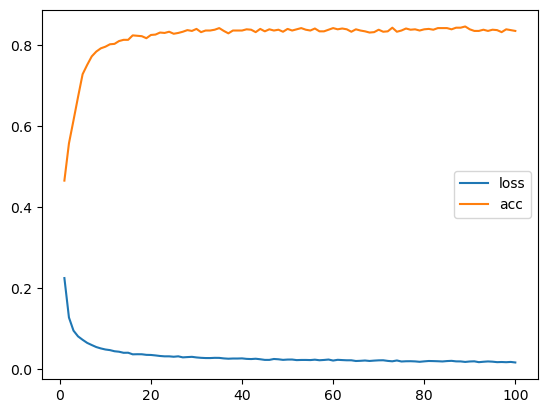

[0.22508839 0.1276278  0.09516783 0.08096132 0.07255697 0.0649207
 0.05962353 0.05460146 0.05122237 0.04858057]


In [15]:
import matplotlib.pyplot as plt
train_loss = np.load(os.path.join('..', 'models', 'finetune_super4', 'tree_train_loss.npy'))
val_acc = np.load(os.path.join('..', 'models', 'finetune_super4', 'tree_val_acc.npy'))
epochs = np.arange(1, train_loss.shape[0]+1)
plt.plot(epochs, train_loss, label='loss')
plt.plot(epochs, val_acc, label='acc')
plt.legend()
plt.show()
print(train_loss[:10])